For this project you're going to need to import the following libraries below. 
Download models and dataset here: https://uwoca-my.sharepoint.com/:f:/g/personal/dobrie25_uwo_ca/IgDX7Q0KWqEOSoJ6k7BaC7pwAc87mqphifV5rUMFFefvR6k?e=8S9fBV

In [2]:
import time
import PIL
from PIL import Image
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import re
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import load_model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import *
from tensorflow.keras.callbacks import EarlyStopping
import json
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.base import clone

Next we're going to visualize our dataset at this link. https://www.kaggle.com/datasets/zlatan599/garbage-dataset-classification.

This datatset is going to be used for our image classification model.

The dataset has 6 classes: Trash, Plastic, Paper, Glass, Cardboard, and Metal.
Every photo is of datatype uint8 with pixel intensities of 0-255. They all are 256 x 256 pixels. Every photo is in RGB formatting meaning they all have three channels.
Thus, the size of every photo is (256, 256, 3)
There are 2214 photos of cardboard, 2500 photos of glass, 2084 photos of metal, 2315 photos of paper, 2288 photos of plastic, and 2500 photos of trash. 
That nets us a total of 12901 photos in the dataset.

The dataset will be available in the directory of this github. 

Examples of images we're working with (4 sample images)
cardboard


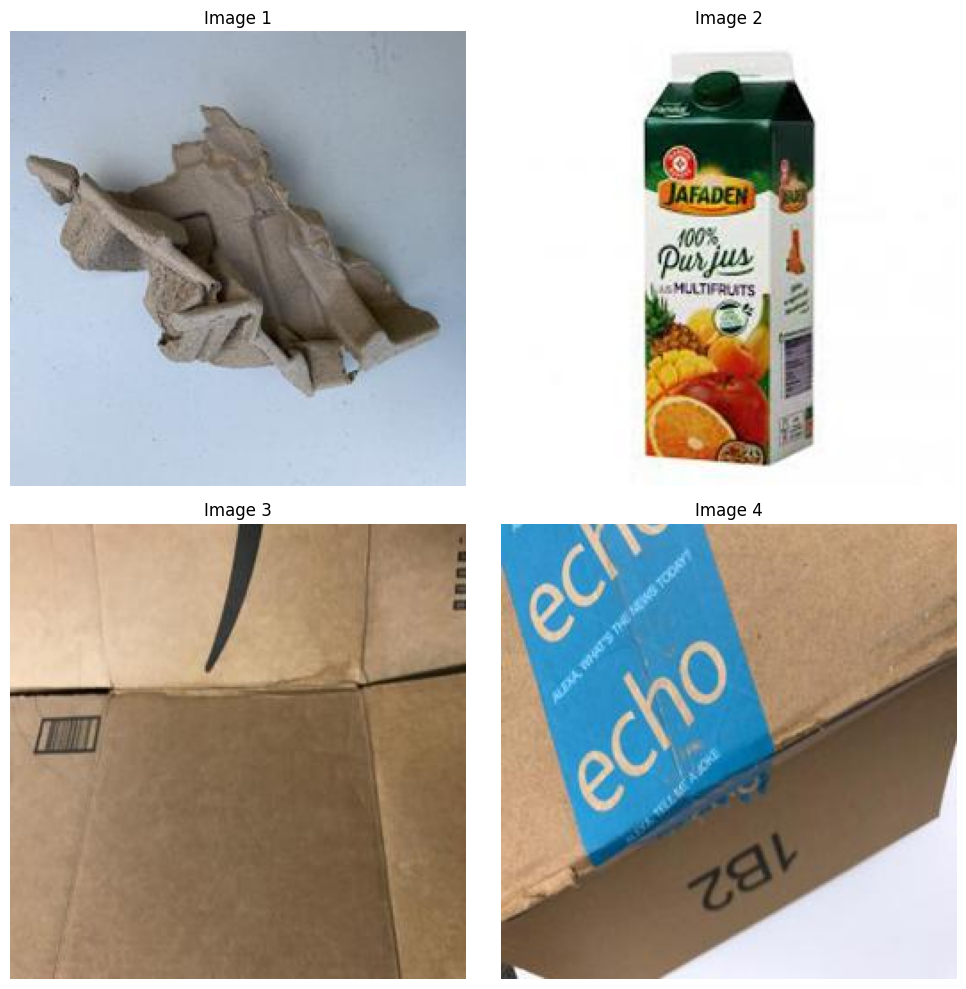

plastic


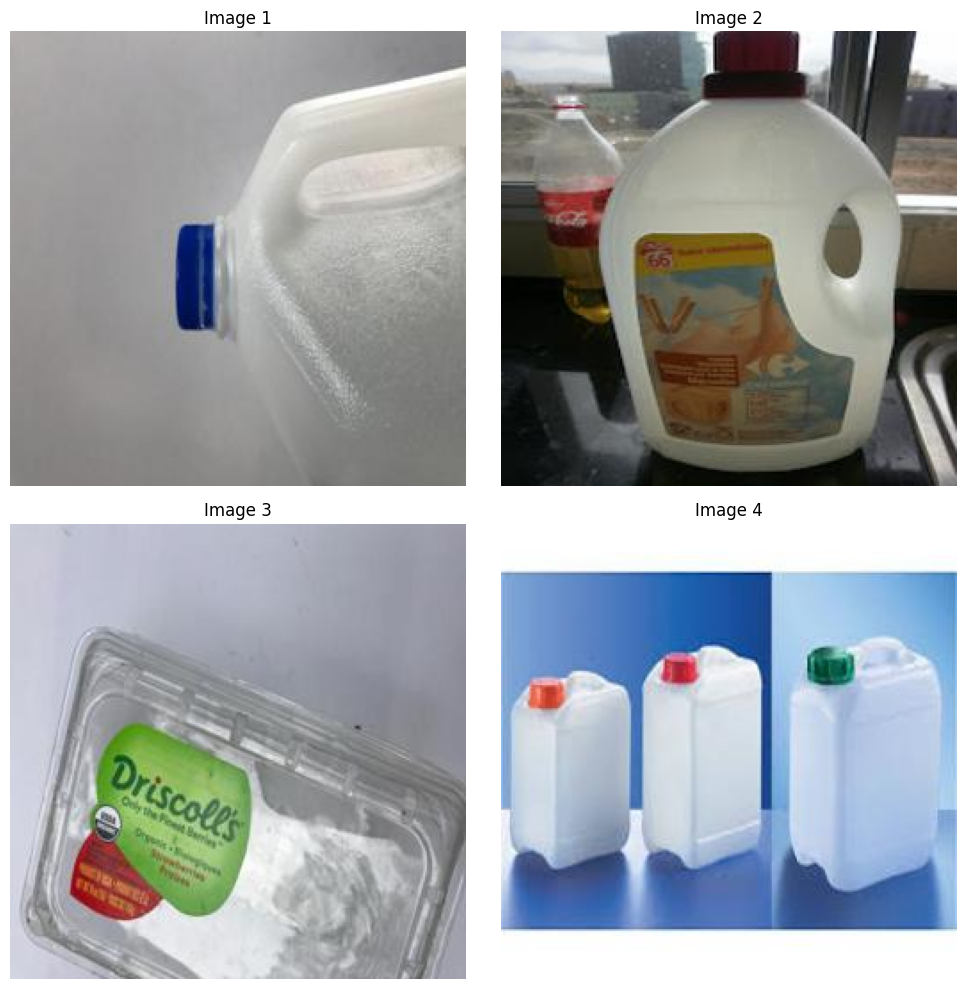

paper


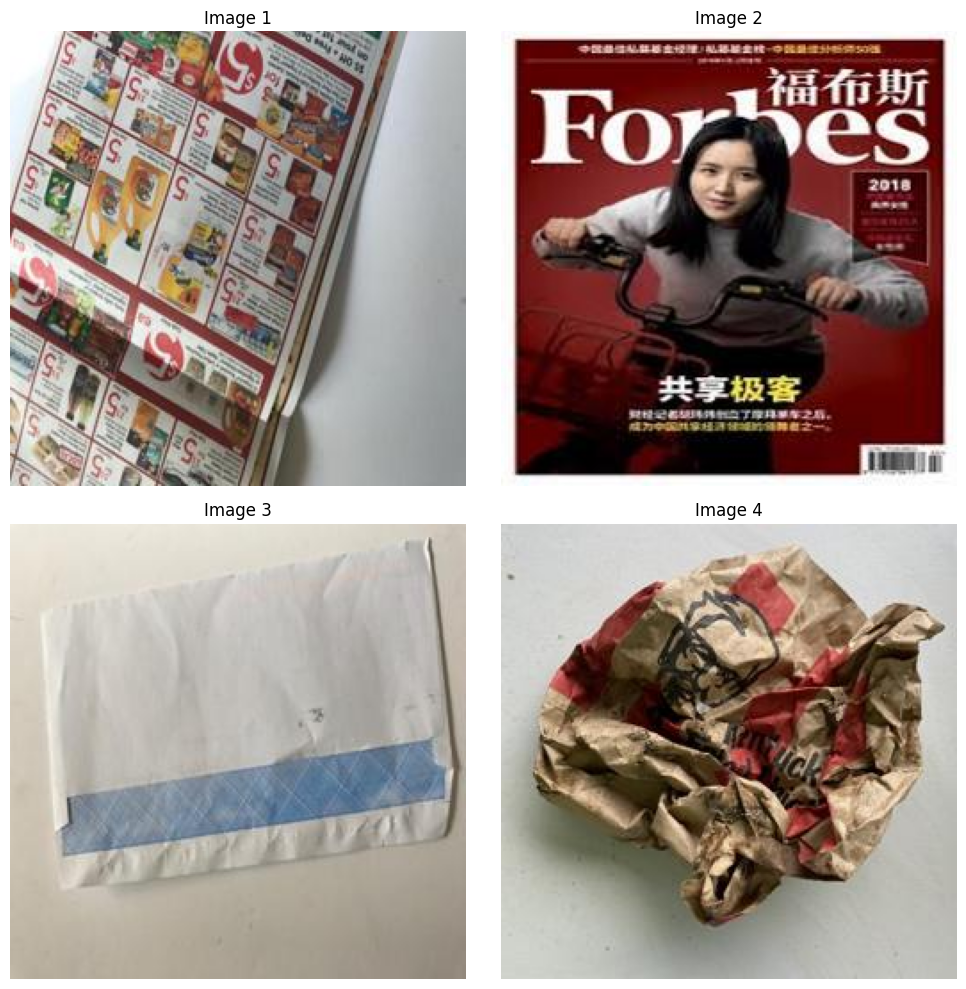

metal


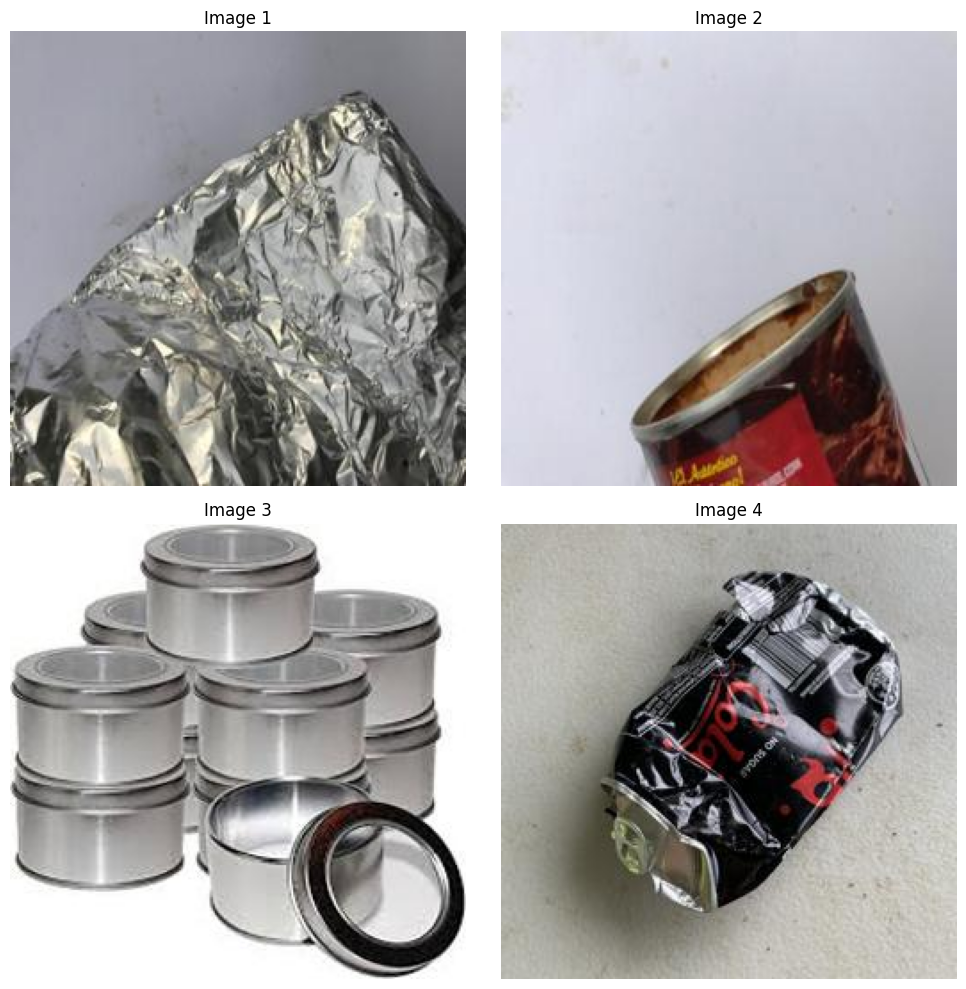

trash


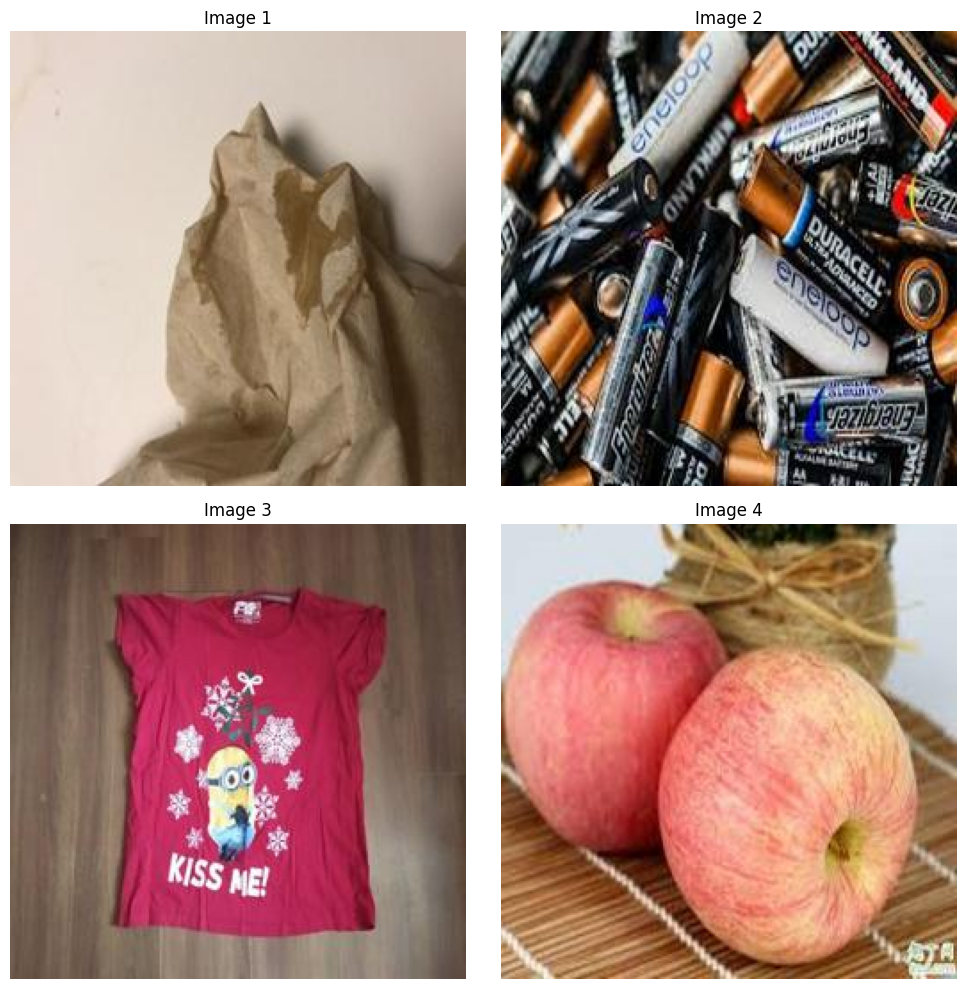

glass


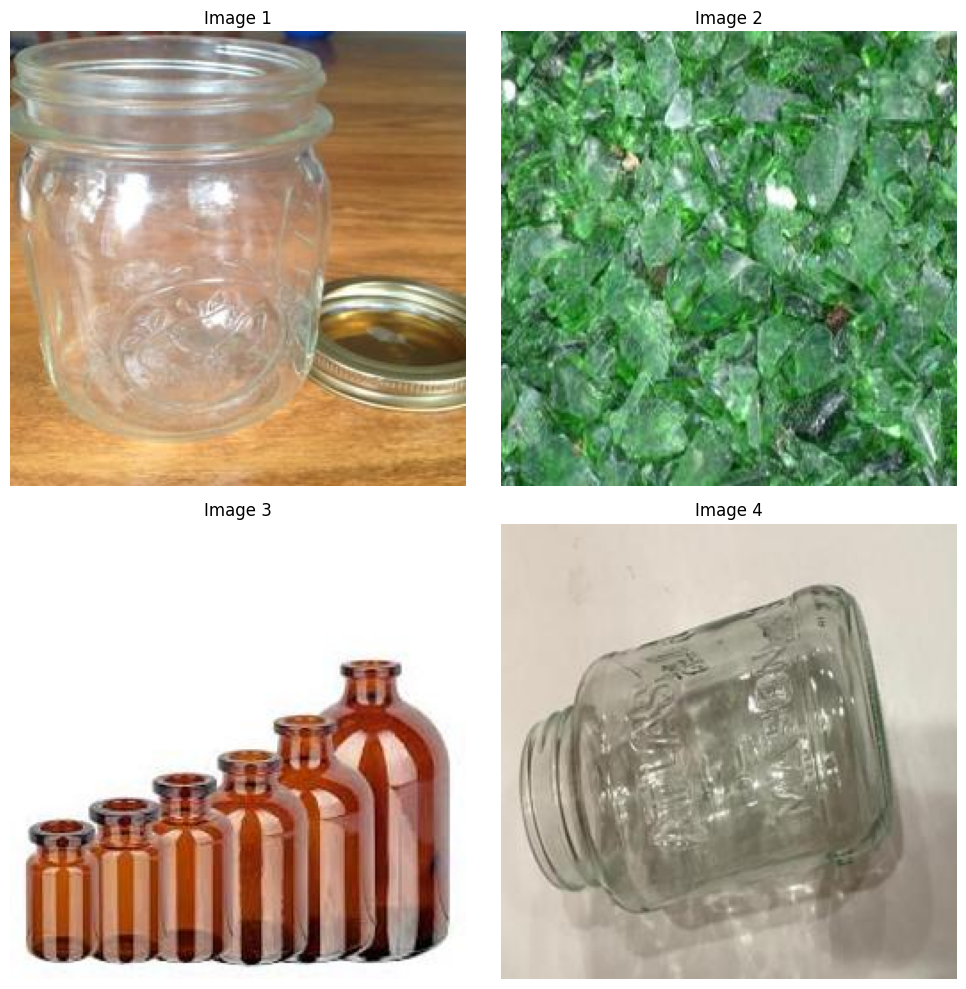

In [9]:
print("Examples of images we're working with (4 sample images)")

def display_four_images(IM1: PIL.Image, IM2: PIL.Image, IM3: PIL.Image,IM4: PIL.Image):

    plt.figure(figsize=(10,10))

    images = [IM1, IM2, IM3, IM4]
    titles = ["Image 1", "Image 2", "Image 3", "Image 4"]

    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(2, 2, i)   # 2 rows, 2 columns
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

IM1 = Image.open("Garbage_Dataset_Classification\images\cardboard\cardboard_02537.jpg").convert("RGB")
IM2 = Image.open("Garbage_Dataset_Classification\images\cardboard\cardboard_03117.jpg").convert("RGB")
IM3 = Image.open("Garbage_Dataset_Classification\images\cardboard\cardboard_00799.jpg").convert("RGB")
IM4 = Image.open("Garbage_Dataset_Classification\images\cardboard\cardboard_00173.jpg").convert("RGB")
IM5 = Image.open("Garbage_Dataset_Classification\images\plastic\plastic_00208.jpg").convert("RGB")
IM6 = Image.open("Garbage_Dataset_Classification\images\plastic\plastic_01357.jpg").convert("RGB")
IM7 = Image.open("Garbage_Dataset_Classification\images\plastic\plastic_02241.jpg").convert("RGB")
IM8 = Image.open("Garbage_Dataset_Classification\images\plastic\plastic_03184.jpg").convert("RGB")
IM9 = Image.open("Garbage_Dataset_Classification\images\paper\paper_00111.jpg").convert("RGB")
IM10 = Image.open("Garbage_Dataset_Classification\images\paper\paper_00656.jpg").convert("RGB")
IM11 = Image.open("Garbage_Dataset_Classification\images\paper\paper_01423.jpg").convert("RGB")
IM12 = Image.open("Garbage_Dataset_Classification\images\paper\paper_02858.jpg").convert("RGB")
IM13 = Image.open("Garbage_Dataset_Classification\images\metal\metal_00159.jpg").convert("RGB")
IM14 = Image.open("Garbage_Dataset_Classification\images\metal\metal_00855.jpg").convert("RGB")
IM15 = Image.open("Garbage_Dataset_Classification\images\metal\metal_01792.jpg").convert("RGB")
IM16 = Image.open("Garbage_Dataset_Classification\images\metal\metal_02398.jpg").convert("RGB")
IM17 = Image.open("Garbage_Dataset_Classification\\images\\trash\\trash_00026.jpg").convert("RGB")
IM18 = Image.open("Garbage_Dataset_Classification\\images\\trash\\trash_01634.jpg").convert("RGB")
IM19 = Image.open("Garbage_Dataset_Classification\\images\\trash\\trash_03384.jpg").convert("RGB")
IM20 = Image.open("Garbage_Dataset_Classification\\images\\trash\\trash_09977.jpg").convert("RGB")
IM21 = Image.open("Garbage_Dataset_Classification\images\glass\glass_04706.jpg").convert("RGB")
IM22 = Image.open("Garbage_Dataset_Classification\images\glass\glass_02065.jpg").convert("RGB")
IM23 = Image.open("Garbage_Dataset_Classification\images\glass\glass_00925.jpg").convert("RGB")
IM24 = Image.open("Garbage_Dataset_Classification\images\glass\glass_00041.jpg").convert("RGB")

print("cardboard")
display_four_images(IM1, IM2, IM3, IM4)
print("plastic")
display_four_images(IM5, IM6, IM7, IM8)
print("paper")
display_four_images(IM9, IM10, IM11, IM12)
print("metal")
display_four_images(IM13, IM14, IM15, IM16)
print("trash")
display_four_images(IM17, IM18, IM19, IM20)
print("glass")
display_four_images(IM21, IM22, IM23, IM24)

After observing some photos chosen from the dataset, multiple issues arises. 
Observing the images in the trash class. There are photos of Batteries, Clothes, and Organic waste. From a real world application point of view this is not helpful.
Clothes can be donated, Organic waste goes in the green bin, and batteries can be recycled. These aren't trash and will not help our model in the training and testing process.
To fix this we manually removed all the images containing clothes, organic waste, and batteries. Since this is a six class classifier, we will not be including these as classes.
Next, additional photos will have to be manually added to compensate for the loss of data.
The new updated dataset is also included in this github.

Next we need to load the new dataset. These new images are not going to be in the (256, 256, 3) shape, so we're going to have to resize the images.
Our first option is to load every image in a numpy array, but that may lead to out of memory errors on systems with low RAM.
Our second option, we can load our dataset and achieve augmentation as well by using keras's ImageDataGenerator class.

In [2]:
#First Option
y_dataset = []
x_dataset = []
category_map = {
    "cardboard": 0,
    "glass": 1,
    "metal": 2,
    "paper": 3,
    "plastic": 4,
    "trash": 5,
}
for [root, dir, files] in os.walk("Garbage_Dataset_Classification_new\images\\"):
    for file in files:
        filename = os.path.splitext(file)[0]
        filename = re.sub(r'[\d_]+', '', filename)
        filename = filename.lower()
        img_path = os.path.join("Garbage_Dataset_Classification_new\images\\", filename, file)
        IM = Image.open(img_path).convert("RGB")
        IM = IM.resize((256, 256))
        IM_Matrix = np.array(IM)
        x_dataset.append(IM_Matrix)
        y_dataset.append(category_map[filename])
Y_dataset = np.array(y_dataset).astype("uint8") 
X_dataset = np.array(x_dataset)
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset,
    Y_dataset,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
X_train = np.array(X_train)
X_val = np.array(X_test)
y_val = np.array(y_test)
y_train = np.array(y_train)
X_train = X_train.astype("float32")/255.0
X_val = X_val.astype("float32")/255.0
y_val = to_categorical(y_val, 6)
y_train = to_categorical(y_train, 6)
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator()
batch_size = 32
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size,
    shuffle=True
)
val_generator = test_datagen.flow(
    X_val,
    y_val,
    batch_size=batch_size,
    shuffle=False
)

In [3]:
#Second Option
img_size = (256, 256)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    "Garbage_Dataset_Classification_new/images",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    "Garbage_Dataset_Classification_new/images",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    seed=42
)

Found 10485 images belonging to 6 classes.
Found 2618 images belonging to 6 classes.


Next we will build a simple CNN model. 
First layer: Convolution layer with 32 filters, activation relu, and a 3x3 kernel size
Second layer: Convolution layer with 64 filters, activation relu, and a 3x3 kernel size
Third layer: Maxpool layer of size 2x2
Fourth layer: Convolution layer with 64 filters, activation relu, and a 3x3 kernel size
Fifth layer: Maxpool layer of size 2x2
Sixth layer: Flaten layer to 1D
Seventh layer: Fully-connected layer with 64 units, activation relu
Eight layer: Fully-connected layer with 6 classes, activation softmax

In [4]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

Finally, we want to train our CNN model

In [32]:
early_stop = EarlyStopping(
    monitor='val_loss',        # watch validation loss
    patience=7,                # stop if no improvement for 5 epochs
    restore_best_weights=True,  # go back to best epoch
)
start = time.time()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train_generator, epochs=60, validation_data=val_generator, callbacks=[early_stop])
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 1/60
328/328 [==============================] - 55s 165ms/step - loss: 1.5774 - accuracy: 0.3886 - val_loss: 1.3472 - val_accuracy: 0.5109
Epoch 2/60
328/328 [==============================] - 54s 164ms/step - loss: 1.2932 - accuracy: 0.5092 - val_loss: 1.2340 - val_accuracy: 0.5433
Epoch 3/60
328/328 [==============================] - 54s 164ms/step - loss: 1.1785 - accuracy: 0.5574 - val_loss: 1.1834 - val_accuracy: 0.5975
Epoch 4/60
328/328 [==============================] - 55s 169ms/step - loss: 1.0864 - accuracy: 0.5987 - val_loss: 1.0288 - val_accuracy: 0.6261
Epoch 5/60
328/328 [==============================] - 54s 163ms/step - loss: 1.0262 - accuracy: 0.6234 - val_loss: 0.9473 - val_accuracy: 0.6639
Epoch 6/60
328/328 [==============================] - 54s 164ms/step - loss: 0.9686 - accuracy: 0.6485 - val_loss: 0.9115 - val_accuracy: 0.6742
Epoch 7/60
328/328 [==============================] - 54s 165ms/step - loss: 0.9254 - accuracy: 0.6642 - val_loss: 0.8651 - val_ac

Next we save the model and the training history

In [33]:
import json
model.save('CNN_clf.keras')
with open('training_history.json', 'w') as file:
    json.dump(history.history, file)

In [2]:
with open('training_history.json', 'r') as file:
    history = json.load(file)
model = keras.models.load_model('CNN_clf.keras')

Next we plot the learning curves from training

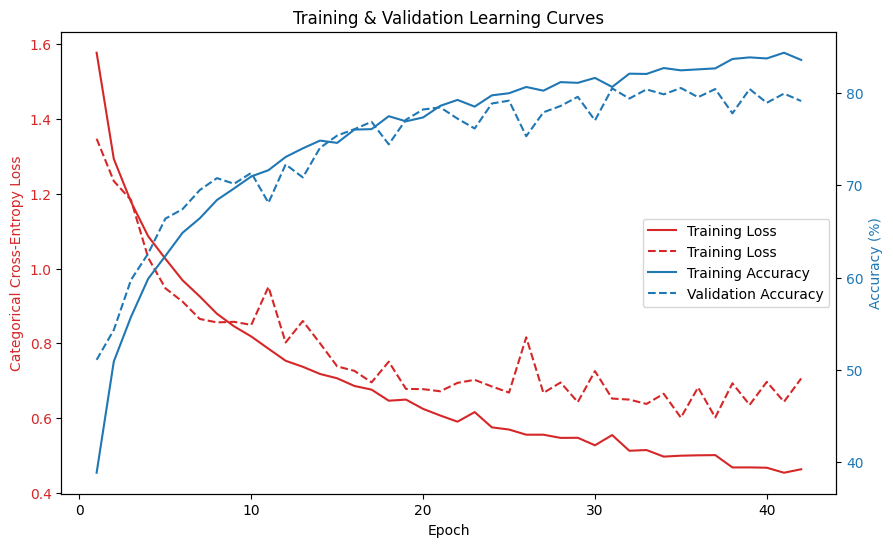

In [ ]:
#train_loss = history.history['loss'] Uncomment these lines of code if you actually re-trained the CNN
#val_loss   = history.history['val_loss']
#train_acc  = np.array(history.history['accuracy']) * 100
#val_acc    = np.array(history.history['val_accuracy']) * 100
train_loss = history['loss']
val_loss   = history['val_loss']
train_acc  = np.array(history['accuracy']) * 100
val_acc    = np.array(history['val_accuracy']) * 100

epochs = range(1, len(train_loss) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Categorical Cross-Entropy Loss', color='tab:red')
ax1.plot(epochs, train_loss, color='tab:red', linestyle='-', label='Training Loss')
ax1.plot(epochs, val_loss, color='tab:red', linestyle='--', label='Training Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(epochs, train_acc, color='tab:blue', linestyle='-', label='Training Accuracy')
ax2.plot(epochs, val_acc,   color='tab:blue', linestyle='--', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right')

plt.title('Training & Validation Learning Curves')
plt.show()

Next we plot the accuracy, F1-score, precision, recall, confusion matrix, ROC curve, and AUC for the CNN on a test split we created, provided in the github

In [4]:
y_test = []
x_test = []
category_map = {
    "cardboard": 0,
    "glass": 1,
    "metal": 2,
    "paper": 3,
    "plastic": 4,
    "trash": 5,
}
for [root, dir, files] in os.walk("Test Split\\Images\\"):
    for file in files:
        filename = os.path.splitext(file)[0]
        filename = re.sub(r'[\d_]+', '', filename)
        filename = filename.lower()
        img_path = os.path.join("Test Split\\Images\\", filename, file)
        IM = Image.open(img_path).convert("RGB")
        IM = IM.resize((256, 256))
        IM_Matrix = np.array(IM)
        x_test.append(IM_Matrix)
        y_test.append(category_map[filename])
y_test = np.array(y_test).astype("uint8") 
x_test = np.array(x_test)
x_test = x_test.astype("float32")/255.0

75/75 [==============================] - 4s 13ms/step
CNN on CNN features - Test accuracy: 0.8282828282828283
\CNN classification report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       405
           1       0.88      0.79      0.83       465
           2       0.83      0.80      0.82       419
           3       0.88      0.84      0.86       486
           4       0.76      0.89      0.82       518
           5       0.66      0.47      0.55        83

    accuracy                           0.83      2376
   macro avg       0.81      0.78      0.79      2376
weighted avg       0.83      0.83      0.83      2376

\CNN confusion matrix:
[[360   2   6   9  27   1]
 [  9 366  29  11  46   4]
 [ 17  24 334  12  28   4]
 [ 29   8   7 408  26   8]
 [ 11  13  14  16 461   3]
 [  5   5  10   6  18  39]]
Macro AUC: 0.9672248662629084


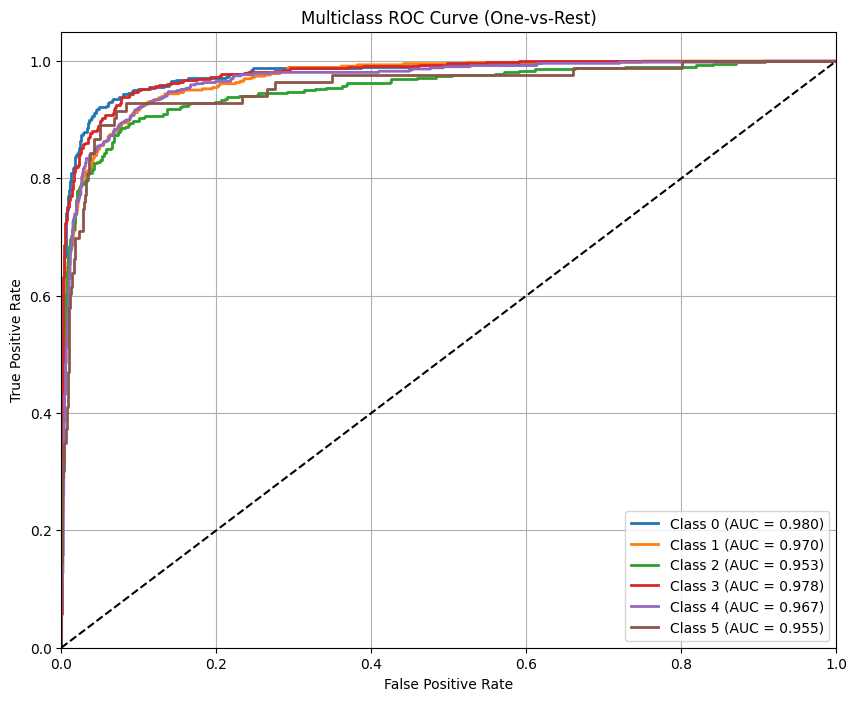

In [5]:
probs_cnn = model.predict(x_test)
y_pred_cnn = np.argmax(probs_cnn, axis=1)
acc_cnn = accuracy_score(y_test, y_pred_cnn)
print("CNN on CNN features - Test accuracy:", acc_cnn)

print("\CNN classification report:")
print(classification_report(y_test, y_pred_cnn))

print("\CNN confusion matrix:")
print(confusion_matrix(y_test, y_pred_cnn))

n_classes = 6

y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_score = probs_cnn

macro_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='macro')
print("Macro AUC:", macro_auc)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

But we're just getting started. Next, we're going to be comparing this CNN model with a couple of other models.
These models include a State Vector Machine, K-Nearest-Neighbor, Random Forest, and XGBoost tree. 
All of these models will be trained on the features extracted by the CNN.
This will test and compare the metrics of each classifier.
First get the feature extracter from our CNN model

In [3]:
model = keras.models.load_model('CNN_clf.keras') #Tensorflow is very finicky

In [4]:
feature_layer = model.layers[-2]

feature_extractor = Model(
    inputs=model.input,
    outputs=feature_layer.output
)

feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21_input (InputLayer  [(None, 256, 256, 3)]    0         
 )                                                               
                                                                 
 conv2d_21 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 conv2d_22 (Conv2D)          (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 126, 126, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 62, 62, 64)       0     

Next, reload all the training data and test data into numpy arrays and do feature extraction with the CNN

In [5]:
y_testset = []
x_testset = []
category_map = {
    "cardboard": 0,
    "glass": 1,
    "metal": 2,
    "paper": 3,
    "plastic": 4,
    "trash": 5,
}
for [root, dir, files] in os.walk("Test Split\\Images\\"):
    for file in files:
        filename = os.path.splitext(file)[0]
        filename = re.sub(r'[\d_]+', '', filename)
        filename = filename.lower()
        img_path = os.path.join("Test Split\\Images\\", filename, file)
        IM = Image.open(img_path).convert("RGB")
        IM = IM.resize((256, 256))
        IM_Matrix = np.array(IM)
        x_testset.append(IM_Matrix)
        y_testset.append(category_map[filename])
y_testset = np.array(y_testset).astype("uint8") 
x_testset = np.array(x_testset)
x_testset = x_testset.astype("float16")/255.0

X_test_feats  = feature_extractor.predict(x_testset,  batch_size=32)
y_test_labels  = y_testset

print("Test feature shape:", X_test_feats.shape)

y_dataset = []
x_dataset = []
category_map = {
    "cardboard": 0,
    "glass": 1,
    "metal": 2,
    "paper": 3,
    "plastic": 4,
    "trash": 5,
}
for [root, dir, files] in os.walk("Garbage_Dataset_Classification_new\images\\"):
    for file in files:
        filename = os.path.splitext(file)[0]
        filename = re.sub(r'[\d_]+', '', filename)
        filename = filename.lower()
        img_path = os.path.join("Garbage_Dataset_Classification_new\images\\", filename, file)
        IM = Image.open(img_path).convert("RGB")
        IM = IM.resize((256, 256))
        IM_Matrix = np.array(IM)
        x_dataset.append(IM_Matrix)
        y_dataset.append(category_map[filename])
Y_dataset = np.array(y_dataset).astype("uint8") 
X_dataset = np.array(x_dataset)
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset,
    Y_dataset,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
y_train_labels = y_train          
y_val_labels  = y_test
X_train = np.array(X_train)
X_val = np.array(X_test)
y_val = np.array(y_test)
y_train = np.array(y_train)
X_train = X_train.astype("float32")/255.0
X_val = X_val.astype("float32")/255.0

X_train_feats = feature_extractor.predict(X_train, batch_size=32)
X_val_feats  = feature_extractor.predict(X_val,  batch_size=32)


X_train = np.concatenate([X_train_feats, X_val_feats], axis=0)
y_train = np.concatenate([y_train_labels, y_val_labels], axis=0)

print("Train feature shape:", X_train.shape)

75/75 [==============================] - 4s 11ms/step
Test feature shape: (2376, 64)
82/82 [==============================] - 1s 13ms/step
Train feature shape: (13103, 64)


Next we need to define four new models, SVM, KNN, RF, XGBoost, and Logistic Regression

In [6]:
svm_clf = SVC(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    probability=True  
)
knn_clf = KNeighborsClassifier(
    n_neighbors=5,      
    metric='minkowski', 
    p=2
)
rf_clf = RandomForestClassifier(
    n_estimators=500,            
    criterion='gini',
    max_depth=None,             
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',        
    n_jobs=-1,                  
    class_weight='balanced_subsample',  
    random_state=42
)
xgb_clf = XGBClassifier(
    n_estimators=500,           
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob', 
    num_class=6,                
    eval_metric='mlogloss',
    n_jobs=-1,
    tree_method='hist'  
    )
meta_clf = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs'
)

Next we need to compare these four models using k-fold cross validation

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "SVM": SVC(
        kernel='rbf',
        C=10.0,
        gamma='scale',
        probability=True
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=5,
        metric='minkowski',
        p=2
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        criterion='gini',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        n_jobs=-1,
        class_weight='balanced_subsample',
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=6,
        eval_metric='mlogloss',
        n_jobs=-1,
        tree_method='hist'
    )
}
scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro"
}

for name, model in models.items():
    cv_results = cross_validate(
        model,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    acc_mean = np.mean(cv_results["test_accuracy"])
    acc_std  = np.std(cv_results["test_accuracy"])
    f1_mean  = np.mean(cv_results["test_f1_macro"])
    f1_std   = np.std(cv_results["test_f1_macro"])

    print(f"{name}:")
    print(f"  Accuracy: {acc_mean:.3f} ± {acc_std:.3f}")
    print(f"  F1-macro: {f1_mean:.3f} ± {f1_std:.3f}")
    print()

SVM:
  Accuracy: 0.882 ± 0.005
  F1-macro: 0.869 ± 0.008

KNN:
  Accuracy: 0.852 ± 0.004
  F1-macro: 0.832 ± 0.006

RandomForest:
  Accuracy: 0.900 ± 0.002
  F1-macro: 0.882 ± 0.007

XGBoost:
  Accuracy: 0.904 ± 0.004
  F1-macro: 0.887 ± 0.009



So the model we would chose would be the random forest model or XGBoost model. Instead of that, we're going to combine all of the models together using ensemble learning.

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_base = clone(svm_clf)
knn_base = clone(knn_clf)
rf_base  = clone(rf_clf)
xgb_base = clone(xgb_clf)

print("Building out-of-fold probabilities for stacking...")

svm_oof = cross_val_predict(
    svm_base, X_train, y_train,
    cv=cv, method='predict_proba', n_jobs=-1
) 

knn_oof = cross_val_predict(
    knn_base, X_train, y_train,
    cv=cv, method='predict_proba', n_jobs=-1
)

rf_oof = cross_val_predict(
    rf_base, X_train, y_train,
    cv=cv, method='predict_proba', n_jobs=-1
)

xgb_oof = cross_val_predict(
    xgb_base, X_train, y_train,
    cv=cv, method='predict_proba', n_jobs=-1
)


Z_train = np.hstack([svm_oof, knn_oof, rf_oof, xgb_oof])

print("Z_train shape:", Z_train.shape)

Building out-of-fold probabilities for stacking...
Z_train shape: (13103, 24)


Next we need to fit our models

In [8]:

meta_clf.fit(Z_train, y_train)
svm_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

c:\miniconda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_class=6, num_parallel_tree=None, ...)

Next we need to test the metrics of these models

SVM on CNN features - Test accuracy: 0.877104377104377

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       405
           1       0.84      0.88      0.86       465
           2       0.91      0.82      0.86       419
           3       0.90      0.90      0.90       486
           4       0.88      0.90      0.89       518
           5       0.74      0.65      0.69        83

    accuracy                           0.88      2376
   macro avg       0.86      0.85      0.85      2376
weighted avg       0.88      0.88      0.88      2376


Confusion matrix:
[[377   5   2   4  16   1]
 [  8 408  17  11  18   3]
 [ 12  31 344  12  16   4]
 [ 20  13   2 437   7   7]
 [  8  21   7  14 464   4]
 [  3   9   5   8   4  54]]
Macro AUC: 0.97871669766679


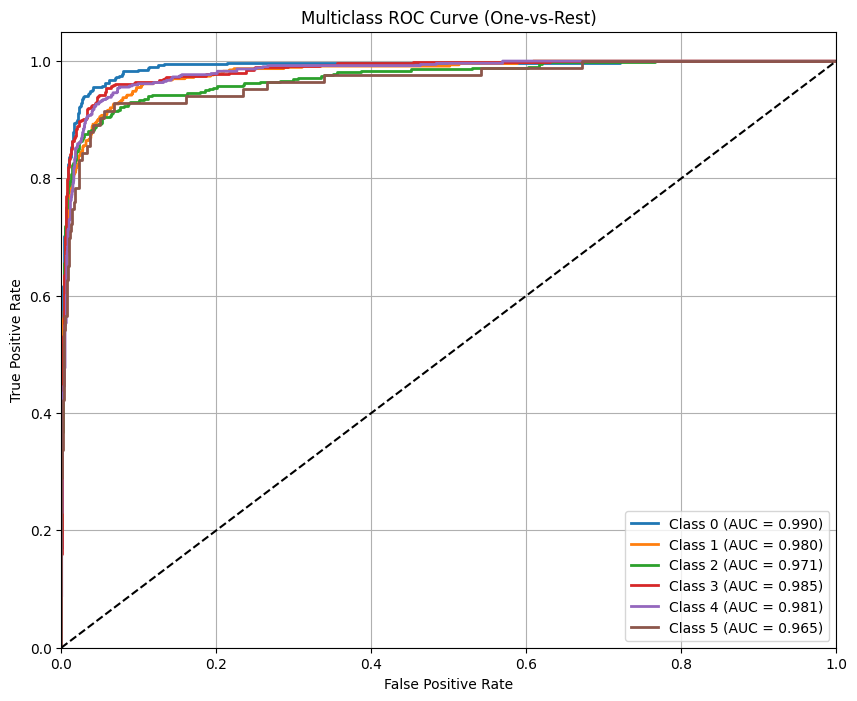

In [10]:
y_pred = svm_clf.predict(X_test_feats)
acc = accuracy_score(y_test_labels, y_pred)
print("SVM on CNN features - Test accuracy:", acc)

print("\nClassification report:")
print(classification_report(y_test_labels, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test_labels, y_pred))

n_classes = 6

y_test_bin = label_binarize(y_test_labels, classes=range(n_classes))
y_score = svm_clf.predict_proba(X_test_feats)

macro_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='macro')
print("Macro AUC:", macro_auc)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

KNN on CNN features - Test accuracy: 0.8476430976430976

Classification report (KNN):
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       405
           1       0.80      0.88      0.84       465
           2       0.87      0.79      0.83       419
           3       0.88      0.89      0.88       486
           4       0.85      0.85      0.85       518
           5       0.70      0.46      0.55        83

    accuracy                           0.85      2376
   macro avg       0.83      0.79      0.81      2376
weighted avg       0.85      0.85      0.85      2376


Confusion matrix (KNN):
[[369   3   4   8  19   2]
 [  9 408  15  11  18   4]
 [ 11  41 330  11  24   2]
 [ 25  11   6 431  11   2]
 [  7  30  12  25 438   6]
 [  6  14  11   6   8  38]]
Macro AUC: 0.9684635820628574


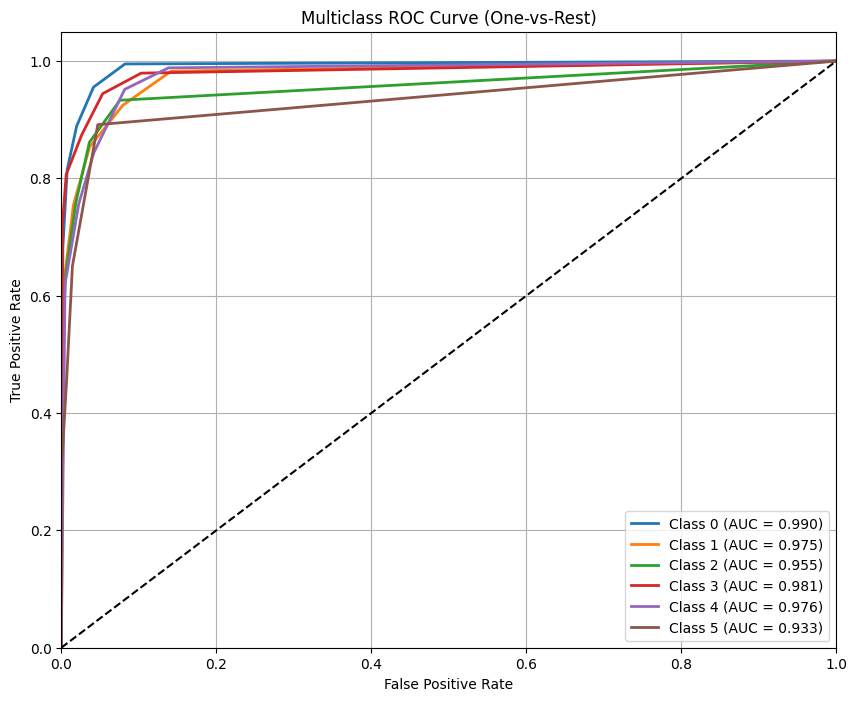

In [11]:
y_pred_knn = knn_clf.predict(X_test_feats)
acc_knn = accuracy_score(y_test_labels, y_pred_knn)
print("KNN on CNN features - Test accuracy:", acc_knn)

print("\nClassification report (KNN):")
print(classification_report(y_test_labels, y_pred_knn))

print("\nConfusion matrix (KNN):")
print(confusion_matrix(y_test_labels, y_pred_knn))

n_classes = 6

y_test_bin = label_binarize(y_test_labels, classes=range(n_classes))
y_score = knn_clf.predict_proba(X_test_feats)

macro_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='macro')
print("Macro AUC:", macro_auc)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Random Forest on CNN features - Test accuracy: 0.9528619528619529

RF classification report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       405
           1       0.94      0.97      0.96       465
           2       0.98      0.90      0.94       419
           3       0.95      0.97      0.96       486
           4       0.95      0.97      0.96       518
           5       0.96      0.83      0.89        83

    accuracy                           0.95      2376
   macro avg       0.95      0.94      0.94      2376
weighted avg       0.95      0.95      0.95      2376


RF confusion matrix:
[[392   2   0   1  10   0]
 [  4 452   4   2   3   0]
 [  9  15 378   4  12   1]
 [  7   4   1 470   2   2]
 [  1   6   1   7 503   0]
 [  0   2   3   9   0  69]]
Macro AUC: 0.9934288746242043


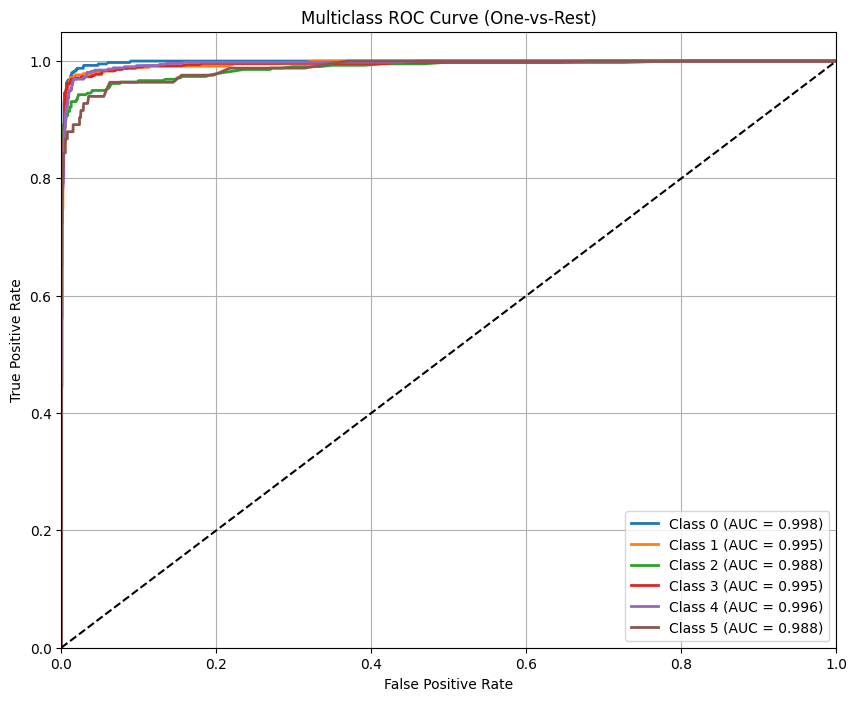

In [12]:
y_pred_rf = rf_clf.predict(X_test_feats)
acc_rf = accuracy_score(y_test_labels, y_pred_rf)
print("Random Forest on CNN features - Test accuracy:", acc_rf)

print("\nRF classification report:")
print(classification_report(y_test_labels, y_pred_rf))

print("\nRF confusion matrix:")
print(confusion_matrix(y_test_labels, y_pred_rf))

n_classes = 6

y_test_bin = label_binarize(y_test_labels, classes=range(n_classes))
y_score = rf_clf.predict_proba(X_test_feats)

macro_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='macro')
print("Macro AUC:", macro_auc)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

XGBoost on CNN features - Test accuracy: 0.9364478114478114

XGBoost classification report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       405
           1       0.93      0.95      0.94       465
           2       0.97      0.88      0.92       419
           3       0.94      0.95      0.95       486
           4       0.92      0.96      0.94       518
           5       0.89      0.84      0.86        83

    accuracy                           0.94      2376
   macro avg       0.93      0.92      0.93      2376
weighted avg       0.94      0.94      0.94      2376


XGBoost confusion matrix:
[[388   2   1   2  12   0]
 [  5 441   6   6   6   1]
 [ 10  14 368   8  17   2]
 [ 10   6   1 461   3   5]
 [  3   7   3   7 497   1]
 [  0   4   2   4   3  70]]
Macro AUC: 0.9899869372008859


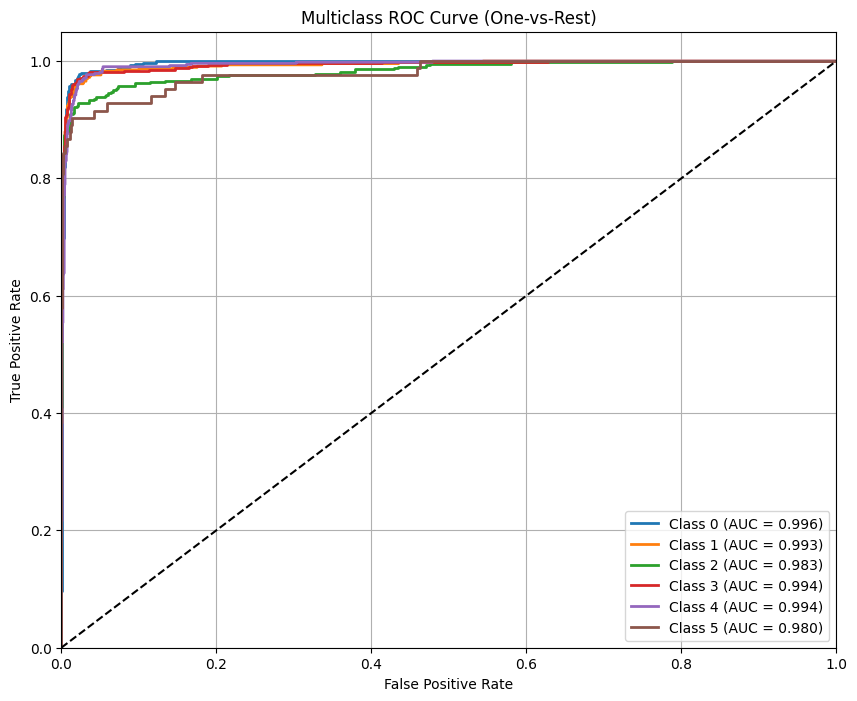

In [13]:
y_pred_xgb = xgb_clf.predict(X_test_feats)
acc_xgb = accuracy_score(y_test_labels, y_pred_xgb)
print("XGBoost on CNN features - Test accuracy:", acc_xgb)

print("\nXGBoost classification report:")
print(classification_report(y_test_labels, y_pred_xgb))

print("\nXGBoost confusion matrix:")
print(confusion_matrix(y_test_labels, y_pred_xgb))

n_classes = 6

y_test_bin = label_binarize(y_test_labels, classes=range(n_classes))
y_score = xgb_clf.predict_proba(X_test_feats)

macro_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='macro')
print("Macro AUC:", macro_auc)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Now with all the models complete, why stop there? Let's try to implement ensemble learning by stacking all the model created thus far using a logistic regression model.

Z shape: (2376, 24)
y_stack shape: (2376,)
Stacked ensemble accuracy (on dataset2): 0.944023569023569

Stacked classification report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       405
           1       0.92      0.96      0.94       465
           2       0.97      0.89      0.93       419
           3       0.95      0.96      0.95       486
           4       0.95      0.96      0.96       518
           5       0.86      0.84      0.85        83

    accuracy                           0.94      2376
   macro avg       0.93      0.93      0.93      2376
weighted avg       0.94      0.94      0.94      2376


Stacked confusion matrix:
[[388   3   1   3   9   1]
 [  4 446   7   4   2   2]
 [  9  16 374   6  12   2]
 [  6   7   1 466   2   4]
 [  2   6   2   7 499   2]
 [  0   5   2   4   2  70]]
Macro AUC: 0.9923031123161666


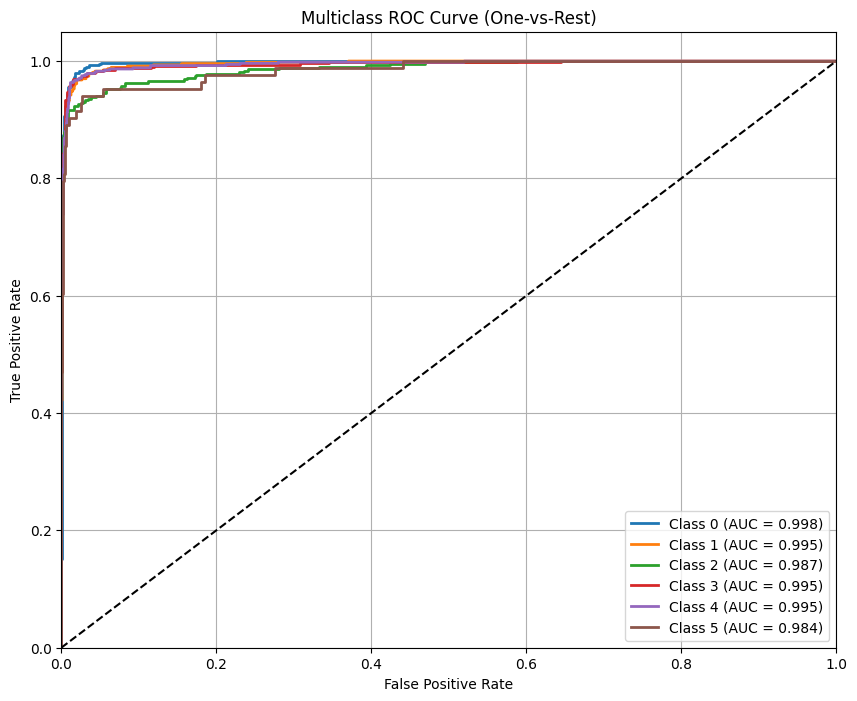

In [15]:
X_stack_feats = X_test_feats                              

y_stack       = y_test_labels                                             

probs_svc  = svm_clf.predict_proba(X_stack_feats)      
probs_knn  = knn_clf.predict_proba(X_stack_feats)      
probs_rf   = rf_clf.predict_proba(X_stack_feats)       
probs_xgb  = xgb_clf.predict_proba(X_stack_feats)      

Z = np.hstack(
    [probs_svc,
     probs_knn,
     probs_rf,
     probs_xgb],
)

print("Z shape:", Z.shape)        
print("y_stack shape:", y_stack.shape) 


y_pred_stack = meta_clf.predict(Z)

acc_stack = accuracy_score(y_stack, y_pred_stack)
print("Stacked ensemble accuracy (on dataset2):", acc_stack)

print("\nStacked classification report:")
print(classification_report(y_stack, y_pred_stack))

print("\nStacked confusion matrix:")
print(confusion_matrix(y_stack, y_pred_stack))

n_classes = 6

y_test_bin = label_binarize(y_test_labels, classes=range(n_classes))
y_score = meta_clf.predict_proba(Z)

macro_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='macro')
print("Macro AUC:", macro_auc)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Wow! That's almost a 13% increase in accuracy compared to the original CNN! Unfontunately the ensemble learning did not increase the accuracy, and our best model is
the random forest train on CNN extracted features.

In [26]:
import joblib

joblib.dump(svm_clf, "svm_model.pkl")
joblib.dump(knn_clf, "knn_model.pkl")
joblib.dump(rf_clf,  "random_forest_model.pkl")
joblib.dump(xgb_clf, "xgboost_model.pkl")
joblib.dump(meta_clf, "stacked_meta_model.pkl")

['stacked_meta_model.pkl']